In [1]:
import csv
import os
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import data

In [2]:
integrated_data = pd.read_csv("../data/processed/five_node_model_integrated_data.csv")

# Normalize continuous data

In [3]:
temp_scaler, precip_scaler, tfp_scaler, asi_scaler = StandardScaler(), MinMaxScaler(), StandardScaler(), MinMaxScaler()
normalized_temp = temp_scaler.fit_transform(np.array(integrated_data["Unweighted_Temp"]).reshape(-1,1)).flatten()
normalized_precip = precip_scaler.fit_transform(np.array(integrated_data["Precipitation"]).reshape(-1,1)).flatten()
# normalized_tfp = tfp_scaler.fit_transform(np.array(integrated_data["ln_TFP_Change"]).reshape(-1,1)).flatten()
normalized_tfp = tfp_scaler.fit_transform(np.array(integrated_data["TFP_Change"]).reshape(-1,1)).flatten()
normalized_asi = asi_scaler.fit_transform(np.array(integrated_data["ASI"]).reshape(-1,1)).flatten()

# Build model

In [4]:
with pm.Model() as model:

    # temperature
    temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
    temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
    temp_std = pm.HalfNormal("temp_std", 1, shape=3)
    temp_posterior = pm.NormalMixture(
        "temp_posterior", 
        temp_mw, 
        temp_prior, 
        temp_std, 
        observed=normalized_temp
    )

    # precip
    precip_prior = pm.HalfNormal("precip_prior", 1)
    precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
    
    # drought
    drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
    drought_likelihood_coefs = pm.Deterministic(
        "drought_likelihood_coefs", 
        pt.transpose(
            pm.math.stack(
                [
                     (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                     (drought_coefs[1] * np.ones(len(integrated_data["Drought"]))) + (drought_coefs[3] * np.ones(len(integrated_data["Drought"])))
                ]
            )
        )
    )
    drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
    drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=integrated_data["Drought"])

    # TFP
    temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
    temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
    precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
    precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
    drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
    tfp_intercept = pm.Normal('tfp_intercept',0,10)
    
    tfp_prior = pm.Deterministic(
        "tfp_prior",
        tfp_intercept +
        (temp_tfp_coef * temp_posterior) +
        (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
        (precip_tfp_coef * precip_posterior) +
        (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
        (drought_tfp_coef * drought_posterior)
    )
    tfp_std = pm.HalfNormal('tfp_std', sigma=10)
    tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=normalized_tfp)
    
    # prior = pm.sample_prior_predictive()
    trace = pm.sample(draws=5000, tune=5000)
    # posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

with open ('../models/temp_precip_drought_tfp_global_large.pkl', 'wb') as buff:
    # pkl.dump({'prior': prior, 'trace': trace, "posterior": posterior}, buff)
    pkl.dump({"trace":trace},buff)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: TensorFromScalar(3)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1082, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/hayden.freedman/miniconda3/envs/pymc_causal_dev/lib/python3.11/site-packages/pytensor/tensor/rewriting/basic.py", line 1106, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])


In [14]:
gv = pm.model_to_graphviz(model)
gv.render(filename='../figures/env_model',format='png', cleanup=True);

# Load model

In [12]:
with open('../models/temp_precip_drought_tfp_global.pkl', 'rb') as buff:
    data = pkl.load(buff)
    prior = data["prior"]
    trace = data["trace"]
    posterior = data["posterior"]

# Plot posterior

/var/folders/q3/myxq41dd4_9c_rx76zlk8f3r0000gn/T/ipykernel_4374/1678283998.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


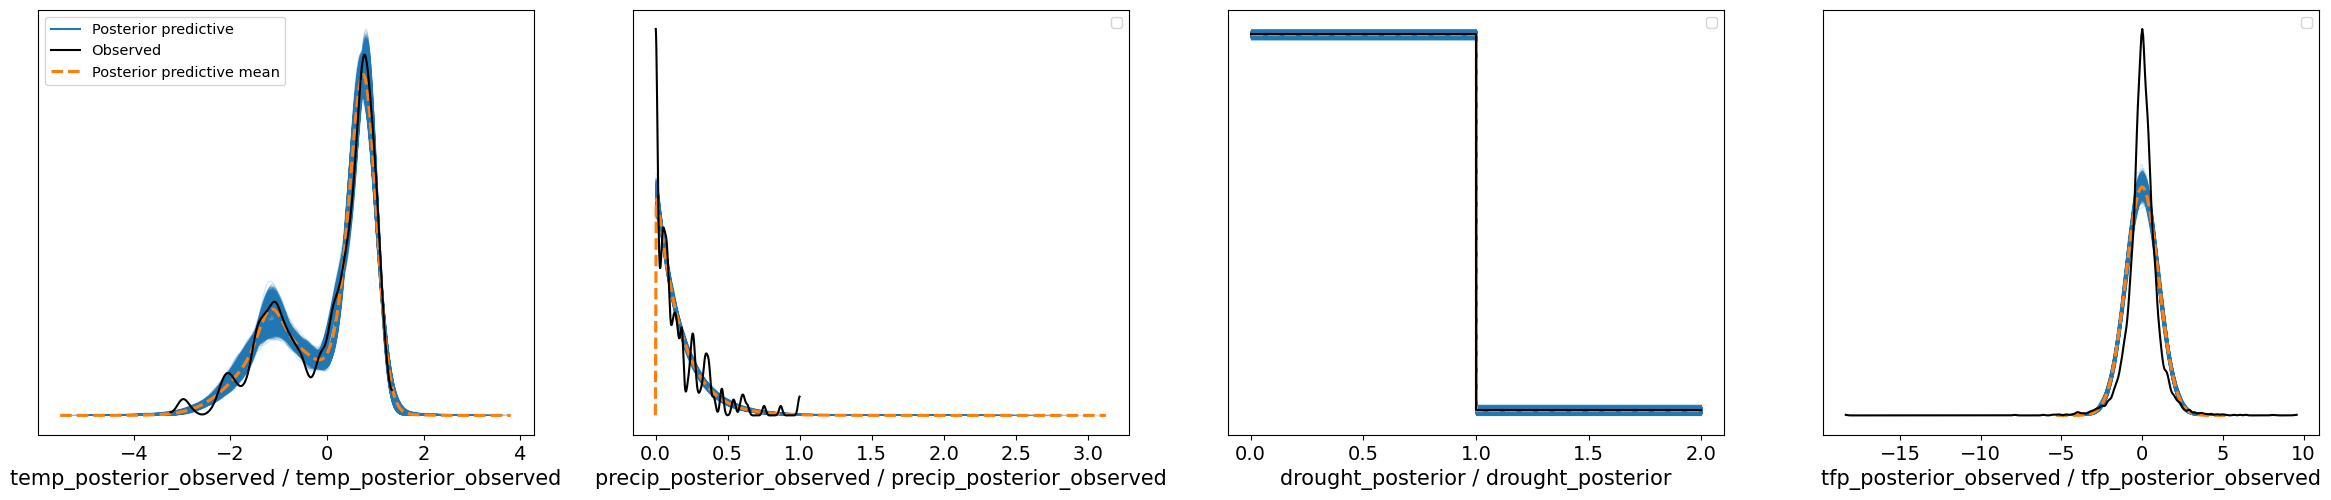

In [121]:
fig = az.plot_ppc(posterior).ravel()[0].figure
fig.show()

# Inverse-normalize sampled data

In [13]:
temp_inverse_sampled = temp_scaler.inverse_transform(np.array(posterior["posterior_predictive"]["temp_posterior"][0][0].data).reshape(-1,1)).flatten()
precip_inverse_sampled = precip_scaler.inverse_transform(np.array(posterior["posterior_predictive"]["precip_posterior"][0][0].data).reshape(-1,1)).flatten()
tfp_inverse_sampled = tfp_scaler.inverse_transform(np.array(posterior["posterior_predictive"]["tfp_posterior"][0][0].data).reshape(-1,1)).flatten()
drought_sampled = posterior["posterior_predictive"]["drought_posterior"][0][0].data

# Assess conditional probabilities

In [4]:
def get_prob_above_zero(data):
    return stats.gaussian_kde(data).integrate_box_1d(0, np.inf)

In [14]:
tfp_high_temp, tfp_low_temp = [], []
for i in range(len(temp_inverse_sampled)):
    if temp_inverse_sampled[i] < 25:
        tfp_low_temp.append(tfp_inverse_sampled[i])
    elif temp_inverse_sampled[i] > 25:
        tfp_high_temp.append(tfp_inverse_sampled[i])

Probability that tfp will increase with low temp:  0.5450717404865876
Probability that tfp will increase with high temp:  0.5175400606323084


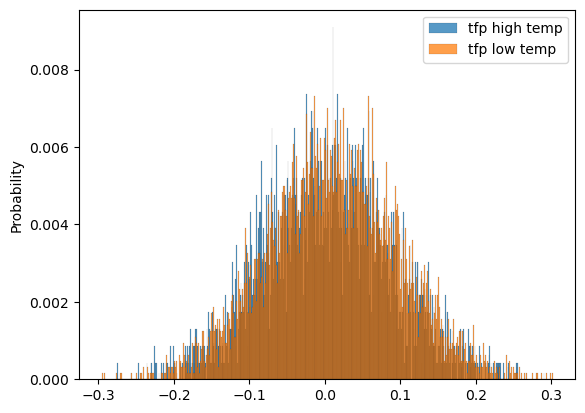

In [15]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(tfp_high_temp), stat='probability', bins=500, ax=ax, label="tfp high temp")
sns.histplot(data=np.array(tfp_low_temp), stat='probability', bins=500, ax=ax, label="tfp low temp")
ax.legend()
high_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/2)] if h.get_x() > 0]
low_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/2):] if h.get_x() > 0]
print("Probability that tfp will increase with low temp: ", np.sum(low_height))
print("Probability that tfp will increase with high temp: ", np.sum(high_height))

In [131]:
tfp_high_precip, tfp_low_precip = [], []
for i in range(len(precip_inverse_sampled)):
    if precip_inverse_sampled[i] < 20:
        tfp_low_precip.append(tfp_inverse_sampled[i])
    elif precip_inverse_sampled[i] > 20:
        tfp_high_precip.append(tfp_inverse_sampled[i])

Probability that tfp will increase with high precip:  0.4959495949594961
Probability that tfp will increase with low precip:  0.5438896189224705


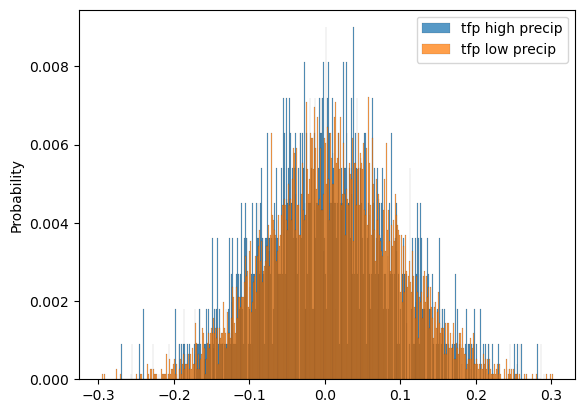

In [132]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(tfp_high_precip), stat='probability', bins=500, ax=ax, label="tfp high precip")
sns.histplot(data=np.array(tfp_low_precip), stat='probability', bins=500, ax=ax, label="tfp low precip")
ax.legend()
high_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/2)] if h.get_x() > 0]
low_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/2):] if h.get_x() > 0]
print("Probability that tfp will increase with high precip: ", np.sum(high_height))
print("Probability that tfp will increase with low precip: ", np.sum(low_height))

In [133]:
tfp_drought, tfp_no_drought = [], []
for i in range(len(precip_inverse_sampled)):
    if drought_sampled[i] == 1:
        tfp_drought.append(tfp_inverse_sampled[i])
    elif drought_sampled[i] == 0:
        tfp_no_drought.append(tfp_inverse_sampled[i])

Probability that tfp will increase with drought:  0.48661417322834644
Probability that tfp will increase with no drought:  0.5421716547118477


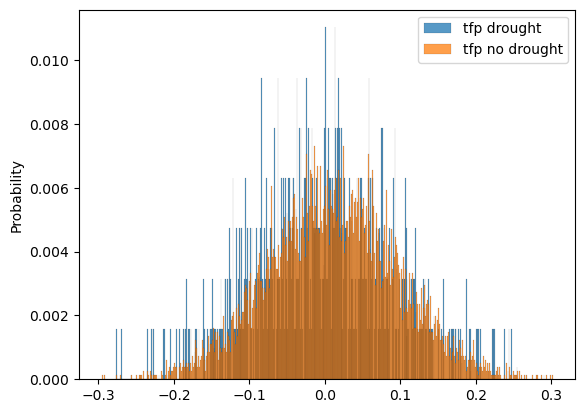

In [134]:
fig, ax = plt.subplots()
sns.histplot(data=np.array(tfp_drought), stat='probability', bins=500, ax=ax, label="tfp drought")
sns.histplot(data=np.array(tfp_no_drought), stat='probability', bins=500, ax=ax, label="tfp no drought")
ax.legend()
drought_height = [h.get_height() for h in ax.patches[:int(len(ax.patches)/2)] if h.get_x() > 0]
no_drought_height = [h.get_height() for h in ax.patches[int(len(ax.patches)/2):] if h.get_x() > 0]
print("Probability that tfp will increase with drought: ", np.sum(drought_height))
print("Probability that tfp will increase with no drought: ", np.sum(no_drought_height))

In [135]:
drought_high_temp_sampled = []
drought_low_temp_sampled = []
drought_low_temp_real = []
drought_high_temp_real = []
drought_high_precip_sampled = []
drought_low_precip_sampled = []
drought_high_precip_real = []
drought_low_precip_real = []

for i in range(len(temp_inverse_sampled)):
    if temp_inverse_sampled[i] < 15:
        drought_low_temp_sampled.append(drought_sampled[i])
    elif temp_inverse_sampled[i] > 15:
        drought_high_temp_sampled.append(drought_sampled[i])
    if precip_inverse_sampled[i] < 5:
        drought_low_precip_sampled.append(drought_sampled[i])
    elif precip_inverse_sampled[i] > 5:
        drought_high_precip_sampled.append(drought_sampled[i])
    if integrated_data["Unweighted_Temp"][i] < 15:
        drought_low_temp_real.append(integrated_data["Drought"][i])
    elif integrated_data["Unweighted_Temp"][i] > 15:
        drought_high_temp_real.append(integrated_data["Drought"][i])
    if integrated_data["Precipitation"][i] < 5:
        drought_low_precip_real.append(integrated_data["Drought"][i])
    elif integrated_data["Precipitation"][i] > 5:
        drought_high_precip_real.append(integrated_data["Drought"][i])

print("sampled drought high temp:", np.mean(drought_high_temp_sampled))
print("real drought high temp:", np.nanmean(drought_high_temp_real))
print("sampled drought low temp:", np.mean(drought_low_temp_sampled))
print("real drought low temp:", np.nanmean(drought_low_temp_real))

print("sampled drought high precip:", np.mean(drought_high_precip_sampled))
print("real drought high precip:", np.nanmean(drought_high_precip_real))
print("sampled drought low precip:", np.mean(drought_low_precip_sampled))
print("real drought low precip:", np.nanmean(drought_low_precip_real))

sampled drought high temp: 0.09253218884120172
real drought high temp: 0.08221302998965874
sampled drought low temp: 0.03314917127071823
real drought low temp: 0.03784570596797671
sampled drought high precip: 0.06913769925100825
real drought high precip: 0.07231493367565255
sampled drought low precip: 0.07825839499146273
real drought low precip: 0.06432748538011696


# Build regional models

In [3]:
countries_by_region = {}
data_by_country = {}
data_by_region = {}
for country in set(integrated_data["Country"]):
    region = cc.convert(country, to="UNregion")
    if region not in countries_by_region:
        countries_by_region[region] = []
    countries_by_region[region].append(country)
for region, countries in countries_by_region.items():
    regional_data = integrated_data.loc[(integrated_data["Country"].isin(countries))]
    data_by_region[region] = regional_data
    for country in countries:
        data_by_country[country] = integrated_data.loc[(integrated_data["Country"]==country)]

In [126]:
no_drought, drought = [], []
mid_afr_data = data_by_region["South America"]
for _, row in mid_afr_data.iterrows():
    if row["Drought"] == 1:
        drought.append(row["TFP"])
    else:
        no_drought.append(row["TFP"])
print(np.nanmean(no_drought))
print(np.nanmean(drought))

92.09638839344261
101.19843499999999


In [19]:
high_temp, low_temp = [], []
east_asia_data = data_by_region["Southern Africa"]
mean_temp = np.mean(east_asia_data["ASI"])
for _, row in east_asia_data.iterrows():
    if row["ASI"] < mean_temp:
        low_temp.append(row["ln_TFP_Change"])
    else:
        high_temp.append(row["Drought"])
print(np.nanmean(high_temp))
print(np.nanmean(low_temp))

0.1411042944785276
0.0018323482455719073


In [3]:
for region, data in data_by_region.items():
    print(region)
    
    # Normalize data
    temp_scaler, precip_scaler, tfp_scaler = StandardScaler(), MinMaxScaler(), StandardScaler()
    normalized_temp = temp_scaler.fit_transform(np.array(data["Unweighted_Temp"]).reshape(-1,1)).flatten()
    normalized_precip = precip_scaler.fit_transform(np.array(data["Precipitation"]).reshape(-1,1)).flatten()
    normalized_tfp = tfp_scaler.fit_transform(np.array(data["ln_TFP_Change"]).reshape(-1,1)).flatten()
    # normalized_asi = asi_scaler.fit_transform(np.array(data["ASI"]).reshape(-1,1)).flatten()
    
    # Build model
    with pm.Model() as model:

        # temperature
        temp_mw = pm.Dirichlet("temp_mixture_weights", np.array([1]*3))
        temp_prior = pm.Normal("temp_prior", 0, 1, shape=(1,3))
        temp_std = pm.HalfNormal("temp_std", 1, shape=3)
        temp_posterior = pm.NormalMixture(
            "temp_posterior", 
            temp_mw, 
            temp_prior, 
            temp_std, 
            observed=normalized_temp
        )
    
        # precip
        precip_prior = pm.HalfNormal("precip_prior", 1)
        precip_posterior = pm.Exponential("precip_posterior", precip_prior, observed=normalized_precip)
        
        # drought
        drought_coefs = pm.Normal("drought_coefs", 0, 1, shape=(4,))
        drought_likelihood_coefs = pm.Deterministic(
            "drought_likelihood_coefs", 
            pt.transpose(
                pm.math.stack(
                    [
                         (drought_coefs[0] * temp_posterior) + (drought_coefs[2] * precip_posterior), 
                         (drought_coefs[1] * np.ones(len(data["Drought"]))) + (drought_coefs[3] * np.ones(len(data["Drought"])))
                    ]
                )
            )
        )
        drought_prior = pm.Deterministic("drought_prior", pm.math.softmax(drought_likelihood_coefs, axis=-1))
        drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=data["Drought"])
        # drought_posterior = pm.Categorical("drought_posterior", drought_prior, observed=data["ASI"])
        # asi_prior = pm.HalfNormal("asi_prior", 1)
        # asi_posterior = pm.Exponential("asi_posterior", asi_prior, observed=normalized_asi)
        
        # TFP
        temp_tfp_coef = pm.Normal('temp_tfp_coef',0,10)
        temp_tfp_coef2 = pm.Normal('temp_tfp_coef2',0,10)
        precip_tfp_coef = pm.Normal("precip_tfp_coef",0,10)
        precip_tfp_coef2 = pm.Normal("precip_tfp_coef2",0,10)
        drought_tfp_coef = pm.Normal('drought_tfp_coef',0,10)
        # REMOVE IF DROUGHT IS CATEGORICAL
        # drought_tfp_coef2 = pm.Normal('drought_tfp_coef2',0,10)
        tfp_intercept = pm.Normal('tfp_intercept',0,10)
        
        tfp_prior = pm.Deterministic(
            "tfp_prior",
            tfp_intercept +
            (temp_tfp_coef * temp_posterior) +
            (temp_tfp_coef2 * pt.sqr(temp_posterior)) +
            (precip_tfp_coef * precip_posterior) +
            (precip_tfp_coef2 * pt.sqr(precip_posterior)) +
            (drought_tfp_coef * drought_posterior)
            # (drought_tfp_coef * asi_posterior) +
            # (drought_tfp_coef2 * pt.sqr(asi_posterior))
        )
        tfp_std = pm.HalfNormal('tfp_std', sigma=10)
        tfp_posterior = pm.Normal('tfp_posterior', mu=tfp_prior, sigma=tfp_std, observed=normalized_tfp)
        
        prior = pm.sample_prior_predictive()
        trace = pm.sample()
        posterior = pm.sample_posterior_predictive(trace, extend_inferencedata=True)
    
with open (f'../models/regional_models_drought_as_asi/temp_precip_drought_tfp_{region}.pkl', 'wb') as buff:
    pkl.dump ({
        'prior': prior, 
        'trace': trace, 
        "posterior": posterior,
        "temp_scaler": temp_scaler,
        "precip_scaler": precip_scaler,
        "tfp_scaler": tfp_scaler,
        # "asi_scaler": asi_scaler,
        "model": model
    }, buff)

NameError: name 'data_by_region' is not defined

# Write variable results to file

In [59]:
dir = "../models/regional_models/"
results = []
headers = [
    "Region","High temp tfp increase","Low temp tfp increase","High precip tfp increase","Low precip tfp increase",
    "Drought tfp increase","No drought tfp increase","Low temp drought","High temp drought","Low precip drought","High precip drought"
]
results.append(headers)

all_files = [dir + file for file in os.listdir(dir)]
all_files.append("../models/temp_precip_drought_tfp_global.pkl")

for file in all_files:
    region = file.split("_")[-1].split(".")[0]
    print(region)
    with open(file, 'rb') as buff:
        
        data = pkl.load(buff)
        prior = data["prior"]
        trace = data["trace"]
        
        posterior = data["posterior"]
        temp_scaler = data["temp_scaler"]
        precip_scaler = data["precip_scaler"]
        tfp_scaler = data["tfp_scaler"]
        
        temp_inverse_sampled = np.vstack(np.array([[temp_scaler.inverse_transform(np.array(posterior["posterior_predictive"]["temp_posterior"][j][i].data).reshape(-1,1)) for i in range(1000)] for j in range(4)]))
        precip_inverse_sampled = np.vstack(np.array([[precip_scaler.inverse_transform(np.array(posterior["posterior_predictive"]["precip_posterior"][j][i].data).reshape(-1,1)) for i in range(1000)] for j in range(4)]))
        tfp_inverse_sampled = np.vstack(np.array([[tfp_scaler.inverse_transform(np.array(posterior["posterior_predictive"]["tfp_posterior"][j][i].data).reshape(-1,1)) for i in range(1000)] for j in range(4)]))
        drought_sampled = np.vstack(np.array([[posterior["posterior_predictive"]["drought_posterior"][j][i].data for i in range(1000)] for j in range(4)]))
        
        temp_mean = np.mean(temp_inverse_sampled)
        precip_mean = np.mean(precip_inverse_sampled)
        tfp_mean = np.mean(temp_inverse_sampled)

        tot_tfp_high_temp, tot_tfp_low_temp = [], []
        tot_tfp_high_precip, tot_tfp_low_precip = [], []
        tot_tfp_drought, tot_tfp_no_drought = [], []
        tot_drought_low_temp, tot_drought_high_temp = [], []
        tot_drought_low_precip, tot_drought_high_precip = [], []
        
        for i in range(len(temp_inverse_sampled)):
            tfp_high_temp, tfp_low_temp = [], []
            tfp_high_precip, tfp_low_precip = [], []
            tfp_drought, tfp_no_drought = [], []
            drought_low_temp, drought_high_temp = [], []
            drought_low_precip, drought_high_precip = [], []
            
            for j in range(len(temp_inverse_sampled[0])):
                if temp_inverse_sampled[i][j] < temp_mean:
                    tfp_low_temp.append(tfp_inverse_sampled[i][j])
                elif temp_inverse_sampled[i][j] > temp_mean:
                    tfp_high_temp.append(tfp_inverse_sampled[i][j])
                if precip_inverse_sampled[i][j] < precip_mean:
                    tfp_low_precip.append(tfp_inverse_sampled[i][j])
                elif precip_inverse_sampled[i][j] > precip_mean:
                    tfp_high_precip.append(tfp_inverse_sampled[i][j])
                if drought_sampled[i][j] == 1:
                    tfp_drought.append(tfp_inverse_sampled[i][j])
                else:
                    tfp_no_drought.append(tfp_inverse_sampled[i][j])
                if temp_inverse_sampled[i][j] < tfp_mean:
                    drought_low_temp.append(drought_sampled[i][j])
                elif temp_inverse_sampled[i][j] > tfp_mean:
                    drought_high_temp.append(drought_sampled[i][j])
                if precip_inverse_sampled[i][j] < precip_mean:
                    drought_low_precip.append(drought_sampled[i][j])
                elif precip_inverse_sampled[i][j] > precip_mean:
                    drought_high_precip.append(drought_sampled[i][j])

            tot_tfp_high_temp.append(get_prob_above_zero(np.array(tfp_high_temp).squeeze()))
            tot_tfp_low_temp.append(get_prob_above_zero(np.array(tfp_low_temp).squeeze()))
            tot_tfp_high_precip.append(get_prob_above_zero(np.array(tfp_high_precip).squeeze()))
            tot_tfp_low_precip.append(get_prob_above_zero(np.array(tfp_low_precip).squeeze()))
            try:
                tot_tfp_drought.append(get_prob_above_zero(np.array(tfp_drought).squeeze()))
            except ValueError:
                pass
            tot_tfp_no_drought.append(get_prob_above_zero(np.array(tfp_no_drought).squeeze()))
            tot_drought_low_temp.append(np.mean(np.array(drought_low_temp).squeeze()))
            tot_drought_high_temp.append(np.mean(np.array(drought_high_temp).squeeze()))
            tot_drought_low_precip.append(np.mean(np.array(drought_low_precip).squeeze()))
            tot_drought_high_precip.append(np.mean(np.array(drought_high_precip).squeeze()))

        results.append([
            region,
            f"Mean={np.mean(tot_tfp_high_temp)},SD={np.std(tot_tfp_high_temp)}",
            f"Mean={np.mean(tot_tfp_low_temp)},SD={np.std(tot_tfp_low_temp)}",
            f"Mean={np.mean(tot_tfp_high_precip)},SD={np.std(tot_tfp_high_precip)}",
            f"Mean={np.mean(tot_tfp_low_precip)},SD={np.std(tot_tfp_low_precip)}",
            f"Mean={np.mean(tot_tfp_drought)},SD={np.std(tot_tfp_drought)}",
            f"Mean={np.mean(tot_tfp_no_drought)},SD={np.std(tot_tfp_no_drought)}",
            f"Mean={np.mean(tot_drought_low_temp)},SD={np.std(tot_drought_low_temp)}",
            f"Mean={np.mean(tot_drought_high_temp)},SD={np.std(tot_drought_high_temp)}",
            f"Mean={np.mean(tot_drought_low_precip)},SD={np.std(tot_drought_low_precip)}",
            f"Mean={np.mean(tot_drought_high_precip)},SD={np.std(tot_drought_high_precip)}",
        ])

with open("../results/regional_models_with_uncertainty.csv", "w") as write_file:
    writer = csv.writer(write_file)
    for row in results:
        writer.writerow(row)

Middle Africa
Australia and New Zealand
Southern Asia
Northern America
South America
Eastern Asia
South-eastern Asia
Central America
Northern Africa
Western Asia
Caribbean
Northern Europe
Melanesia
Central Asia
Southern Africa
Western Africa
Eastern Europe
Eastern Africa
Western Europe
Southern Europe


# Write parameter results to file

In [41]:
dir = "../models/regional_models/"
results = []
headers = [
    "Region","temp_prior_1","temp_prior_2","temp_prior_3","temp_std_1","temp_std_2","temp_std_3","precip_prior",
    "drought_coef_1","drought_coef_2","drought_coef_3","drought_coef_4","temp_tfp_coef",
    "temp_tfp_coef2","precip_tfp_coef","precip_tfp_coef2","drought_tfp_coef","tfp_intercept","tfp_prior",
    "tfp_std"
]
results.append(headers)

all_files = [dir + file for file in os.listdir(dir)]
all_files.append("../models/temp_precip_drought_tfp_global.pkl")

for file in all_files:
    region = file.split("_")[-1].split(".")[0]
    print(region)
    with open(file, 'rb') as buff:
        
        data = pkl.load(buff)
        trace = data["trace"]["posterior"]
        temp_prior_1 = np.vstack(np.vstack(trace["temp_prior"]))[:,0]
        temp_prior_2 = np.vstack(np.vstack(trace["temp_prior"]))[:,1]
        temp_prior_3 = np.vstack(np.vstack(trace["temp_prior"]))[:,2]
        temp_std_1 = np.vstack(trace["temp_std"])[:,0]
        temp_std_2 = np.vstack(trace["temp_std"])[:,1]
        temp_std_3 = np.vstack(trace["temp_std"])[:,2]
        precip_prior = np.array(trace["precip_prior"])
        drought_coefs_1 = np.vstack(trace["drought_coefs"])[:,0]
        drought_coefs_2 = np.vstack(trace["drought_coefs"])[:,1]
        drought_coefs_3 = np.vstack(trace["drought_coefs"])[:,2]
        drought_coefs_4 = np.vstack(trace["drought_coefs"])[:,3]
        temp_tfp_coef = np.array(trace["temp_tfp_coef"])
        temp_tfp_coef2 = np.array(trace["temp_tfp_coef2"])
        precip_tfp_coef = np.array(trace["precip_tfp_coef"])
        precip_tfp_coef2 = np.array(trace["precip_tfp_coef2"])
        drought_tfp_coef = np.array(trace["drought_tfp_coef"])
        tfp_intercept = np.array(trace["tfp_intercept"])
        tfp_prior = np.array(trace["tfp_prior"])
        tfp_std = np.array(trace["tfp_std"])
        
        results.append([
            region,
            f"Mean={np.mean(temp_prior_1)},SD={np.std(temp_prior_1)}",
            f"Mean={np.mean(temp_prior_2)},SD={np.std(temp_prior_2)}",
            f"Mean={np.mean(temp_prior_3)},SD={np.std(temp_prior_3)}",
            f"Mean={np.mean(temp_std_1)},SD={np.std(temp_std_1)}",
            f"Mean={np.mean(temp_std_2)},SD={np.std(temp_std_2)}",
            f"Mean={np.mean(temp_std_3)},SD={np.std(temp_std_3)}",
            f"Mean={np.mean(precip_prior)},SD={np.std(precip_prior)}",
            f"Mean={np.mean(drought_coefs_1)},SD={np.std(drought_coefs_1)}",
            f"Mean={np.mean(drought_coefs_2)},SD={np.std(drought_coefs_2)}",
            f"Mean={np.mean(drought_coefs_3)},SD={np.std(drought_coefs_3)}",
            f"Mean={np.mean(drought_coefs_4)},SD={np.std(drought_coefs_4)}",
            f"Mean={np.mean(temp_tfp_coef)},SD={np.std(temp_tfp_coef)}",
            f"Mean={np.mean(temp_tfp_coef2)},SD={np.std(temp_tfp_coef2)}",
            f"Mean={np.mean(precip_tfp_coef)},SD={np.std(precip_tfp_coef)}",
            f"Mean={np.mean(precip_tfp_coef2)},SD={np.std(precip_tfp_coef2)}",
            f"Mean={np.mean(drought_tfp_coef)},SD={np.std(drought_tfp_coef)}",
            f"Mean={np.mean(tfp_intercept)},SD={np.std(tfp_intercept)}",
            f"Mean={np.mean(tfp_prior)},SD={np.std(tfp_prior)}",
            f"Mean={np.mean(tfp_std)},SD={np.std(tfp_std)}"
        ])

with open("../results/model_parameters_with_uncertainty.csv", "w") as write_file:
    writer = csv.writer(write_file)
    for row in results:
        writer.writerow(row)

Middle Africa
Australia and New Zealand
Southern Asia
Northern America
South America
Eastern Asia
South-eastern Asia
Central America
Northern Africa
Western Asia
Caribbean
Northern Europe
Melanesia
Central Asia
Southern Africa
Western Africa
Eastern Europe
Eastern Africa
Western Europe
Southern Europe
global


# Remaining issues for paper:
1. Solidify model structure/fixed parameters especially regarding discrete distribution
2. Split up model by region
3. Determine indicative/useful questions to ask model
4. Determine how model can be evaluated for correctness (maybe use 3 sources of error from textbook)
5. Figure out how to represent uncertainty
    - show uncertainty in the parameter space by representing the parameters as distributions
    - show uncertainty in the outcome space by treating each sample as a separate probabilistic estimate